In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
import glob
import roi 

In [3]:
def great_circle_distance(lat1, lon1, lat2, lon2):
    """Distance between two points on the earth surface, in km.
    """
    R = 6371.0 # Radius of the earth in km
    dlon = np.deg2rad(lon2 - lon1)
    dlat = np.deg2rad(lat2 - lat1)
    a = np.sin(dlat/2)**2 + np.cos(np.deg2rad(lat1)) * np.cos(np.deg2rad(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Read and Process one File

A step-by-step break down of what is going on.

In [4]:
# List all filenames in data/tx
filenames = glob.glob('../data/tx/*.csv.gz')
filenames.sort()
print('Number of files:', len(filenames))

files_to_read = filenames[0:1] # Read only the first 1 files
big_traj_csv = pd.DataFrame() # Create an empty dataframe

# Read each file and append to big_traj_csv
for filename in files_to_read:
    traj_csv = pd.read_csv(filename, compression='gzip')
    traj_csv = traj_csv[['altitude', 'groundspeed', 'callsign', 'latitude', 'longitude', 'timestamp']]
    # Add a column called 'dist' to indicate distance to roi.KDFW, using great_circle_distance()
    traj_csv['dist'] = great_circle_distance(traj_csv['latitude'], traj_csv['longitude'], roi.KDFW[1], roi.KDFW[0])
    big_traj_csv = pd.concat([big_traj_csv, traj_csv], ignore_index=True)
    print('Filename: ', filename, 'Number of rows: ', len(traj_csv))

print('Number of rows in big_traj_csv: ', len(big_traj_csv))

Number of files: 210
Filename:  ../data/tx/hrrr17x_0.csv.gz Number of rows:  72762
Filename:  ../data/tx/hrrr17x_1.csv.gz Number of rows:  62189


/var/folders/8k/_h2zg_z51q9fpsbmsh42bd3h0000gn/T/ipykernel_5544/2196894280.py:11: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  traj_csv = pd.read_csv(filename, compression='gzip')


Filename:  ../data/tx/hrrr17x_10.csv.gz Number of rows:  852318
Number of rows in big_traj_csv:  987269


In [5]:
# Drop the rows with distance > roi.ROI_RADIUS
big_traj_csv = big_traj_csv[big_traj_csv['dist'] <= roi.ROI_RADIUS]
print('Number of rows in big_traj_csv after dropping rows with distance > ROI_RADIUS: ', len(big_traj_csv))

Number of rows in big_traj_csv after dropping rows with distance > ROI_RADIUS:  276004


In [6]:
big_traj_csv.head()

,altitude,groundspeed,callsign,latitude,longitude,timestamp,dist
2079,31775.0,499.0,GTI3403,32.637039,-99.107062,2017-01-01 10:03:15+00:00,199.923536
2090,31725.0,499.0,GTI3403,32.637355,-99.104639,2017-01-01 10:03:16+00:00,199.697413
2111,31700.0,499.0,GTI3403,32.637634,-99.102173,2017-01-01 10:03:17+00:00,199.467127
2122,31675.0,499.0,GTI3403,32.638007,-99.099202,2017-01-01 10:03:18+00:00,199.189828
2131,31625.0,499.0,GTI3403,32.638379,-99.095951,2017-01-01 10:03:19+00:00,198.886304


In [7]:
def round_timestamp_to_10s(timestamp):
    """Round a timestamp to the nearest 10 seconds.
    """
    # Parse the timestamp string into a datetime object
    dt = pd.to_datetime(timestamp)
    # Round to the nearest 10 seconds
    dt_rounded = dt.round('10s')
    # Convert back to string
    timestamp_rounded = str(dt_rounded)
    return timestamp_rounded

In [8]:
big_traj_csv['timestamp_rounded'] = big_traj_csv['timestamp'].apply(round_timestamp_to_10s)
big_traj_csv.head()

,altitude,groundspeed,callsign,latitude,longitude,timestamp,dist,timestamp_rounded
2079,31775.0,499.0,GTI3403,32.637039,-99.107062,2017-01-01 10:03:15+00:00,199.923536,2017-01-01 10:03:20+00:00
2090,31725.0,499.0,GTI3403,32.637355,-99.104639,2017-01-01 10:03:16+00:00,199.697413,2017-01-01 10:03:20+00:00
2111,31700.0,499.0,GTI3403,32.637634,-99.102173,2017-01-01 10:03:17+00:00,199.467127,2017-01-01 10:03:20+00:00
2122,31675.0,499.0,GTI3403,32.638007,-99.099202,2017-01-01 10:03:18+00:00,199.189828,2017-01-01 10:03:20+00:00
2131,31625.0,499.0,GTI3403,32.638379,-99.095951,2017-01-01 10:03:19+00:00,198.886304,2017-01-01 10:03:20+00:00


In [9]:
unique_timestamps = big_traj_csv['timestamp_rounded'].unique()
print('Number of unique timestamps: ', len(unique_timestamps))

Number of unique timestamps:  3581


In [10]:
# Uniformly sample 15% of the unique timestamps
sampled_timestamps = np.random.choice(unique_timestamps, size=int(0.15*len(unique_timestamps)), replace=False)
print('Number of sampled timestamps: ', len(sampled_timestamps))

Number of sampled timestamps:  537


In [17]:
def get_occupancy_matrix(traj_pd, grid_lons, grid_lats, timestamp):
    """Compute the occupancy matrix for a given timestamp.
    """
    # Extract the rows with the given timestamp
    traj_pd = traj_pd[traj_pd['timestamp_rounded'] == timestamp]
    # Remove duplicate callsigns
    traj_pd = traj_pd.drop_duplicates(subset='callsign')
    # Initialize the occupancy matrix
    occ_mat = np.zeros((len(grid_lats), len(grid_lons)))
    # Loop over each row in traj_pd
    for i, row in traj_pd.iterrows():
        # Find the index of the grid cell that contains the flight
        lat_idx = np.argmin(np.abs(grid_lats - row['latitude']))
        lon_idx = np.argmin(np.abs(grid_lons - row['longitude']))
        # Increment the count in the corresponding cell of occ_mat
        occ_mat[lat_idx, lon_idx] = row['groundspeed']
    return occ_mat

occ_0 = get_occupancy_matrix(big_traj_csv, roi.grid_lons, roi.grid_lats, sampled_timestamps[0])

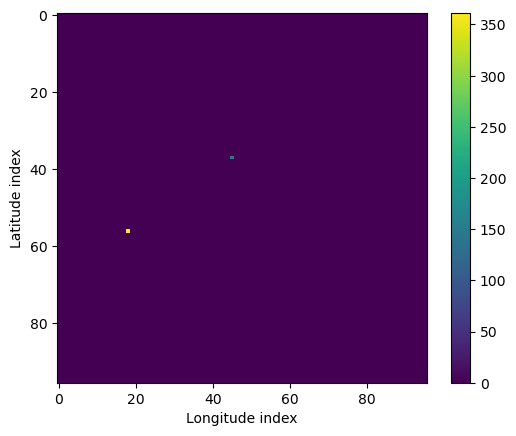

In [19]:
plt.imshow(occ_0)
plt.xlabel('Longitude index')
plt.ylabel('Latitude index')
plt.colorbar()

# Batch processing

To process all the data into matrices, for the training of the VAE.

In [21]:
# Import the dataset from hrrr17t.tgz file, open the OpenSky download notebook to see how to download the data
def create_occupancy_matrices(traj_filename, output_filename, percentage_of_timestamps_per_file):
    traj_csv = pd.read_csv(traj_filename, compression='gzip')
    traj_csv = traj_csv[['altitude', 'groundspeed', 'callsign', 'latitude', 'longitude', 'timestamp']]
    # Add a column called 'dist' to indicate distance to roi.KDFW, using great_circle_distance()
    traj_csv['dist'] = great_circle_distance(traj_csv['latitude'], traj_csv['longitude'], roi.KDFW[1], roi.KDFW[0])
    # Drop the rows with distance > roi.ROI_RADIUS
    traj_csv = traj_csv[traj_csv['dist'] <= roi.ROI_RADIUS]
    # Round the timestamp to the nearest 10 seconds
    traj_csv['timestamp_rounded'] = traj_csv['timestamp'].apply(round_timestamp_to_10s)
    # Get the unique timestamps
    unique_timestamps = traj_csv['timestamp_rounded'].unique()
    # Uniformly sample a percentage of the unique timestamps
    sampled_timestamps = np.random.choice(unique_timestamps, size=int(percentage_of_timestamps_per_file*len(unique_timestamps)), replace=False)
    # Create the occupancy matrices
    occ_mats = []
    for timestamp in sampled_timestamps:
        occ_mat = get_occupancy_matrix(traj_csv, roi.grid_lons, roi.grid_lats, timestamp)
        occ_mats.append(occ_mat)
    # Convert occ_mats to a numpy array
    occ_mats = np.array(occ_mats)
    # Save occ_mats to a numpy file compressed with gzip
    np.savez_compressed(output_filename, occ_mats=occ_mats)

In [22]:
!mkdir -p ../data/tx_occupancy_matrices

In [23]:
create_occupancy_matrices(filenames[0], '../data/tx_occupancy_matrices/occ_mats_0.npz', 0.15)

In [26]:
occ0 = np.load('../data/tx_occupancy_matrices/occ_mats_0.npz')['occ_mats']

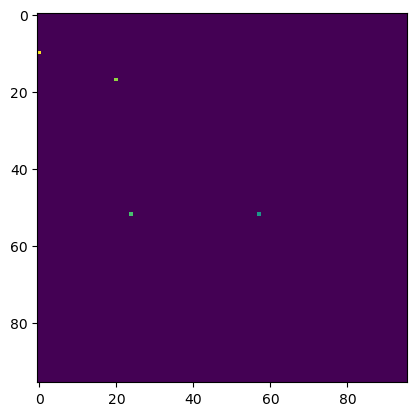

In [29]:
plt.imshow(occ0[25])